<a href="https://colab.research.google.com/github/gever/python_notebooks/blob/master/AquariumPuzzle_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/gever/python_notebooks/master?filepath=AquariumPuzzle_prototype.ipynb)

In [0]:
# All thanks goes to the great puzzle site https://www.puzzle-aquarium.com/ for
# introducing aquarium puzzles to our household.
#
# TO PLAY:
# 1. hit Runtime/Run all to generate a new board
# 2. scroll all the way down to the end of the notebook
# 3. play!
#
# This notebook is my attempt to figure out how to generate solvable puzzles of
# various complexities. Fair warning: this code was largely written on airplanes
# and a sailboat while on vacation in the Virgin Islands.
#
# Outline of current approach:
# - start with an empty board
# - drop N random walkers on the board to leave trails
# - turn their paths into "regions"
# - pour water into some of the regions (see the "rain" function)
#

from random import randint, choice, seed
from IPython.display import SVG

# size of the board
BD_W = 10
BD_H = 10

# various cell values
NOT_MARKED = -1
WATER = 10
AIR = 11

SEED = 1235 # can be up to six digits
if False: # same puzzle every time or generate a random puzzle every run
  seed(SEED)

In [0]:
# the "logic" that builds a playable puzzle
class game:
    def __init__(self):
        self.reset()
        self.make_tanks(4, 8, 20) # inscrutable values!
        self.mark_regions()
        self.rain(50, 5)          # more inscrutable values!
        self.zero_fix()
        
    def reset(self):
        self.board = []     # where the tank borders are developed
        self.regions = []   # analysis of the tanks yields regions
        self.region_dict = {} # every region has a unique ID
        self.water = []     # where water gets poured into regions
        self.blank = '0'

        # set all tiles to "blank" state
        for i in range(BD_W*BD_H):
            self.board.append(self.blank)
            self.regions.append(NOT_MARKED)
            self.water.append(NOT_MARKED)
           
    def _render(self, bd):
        for row in range(BD_H):
            s = ""
            for col in range(BD_W):
                s += str(self._getv(bd, col, row))
                # s += ' '
            print(s)
    
    def render(self):
        self._render(self.board)
    
    # generalized "board" set/get
    def _getv(self, b, x, y):
        return b[y*BD_W+x]
    
    def _setv(self, b, x, y, v):
        b[y*BD_W+x] = v
    
    # convenience "board" set/get functions
    def getv(self, x, y):
        return self._getv(self.board, x, y)
    
    def setv(self, x, y, v):
        self._setv(self.board, x, y, v)
    
    # wander a given length of steps with a value as trail
    def random_walk(self, v, length):
        # find a place to start
        found = False
        x = 0
        y = 0
        for i in range(10):
            x = randint(0, BD_W-1)
            y = randint(0, BD_H-1)
            if self.getv(x, y) == self.blank:
                found = True
                break
        if found:
            for i in range(length):
                self.setv(x, y, v)
                if randint(0,1) == 1:
                    x += choice([-1, 1])
                else:
                    y += choice([-1, 1])
                x = 0 if x < 0 else x
                y = 0 if y < 0 else y
                x = BD_W-1 if x >= BD_W else x
                y = BD_H-1 if y >= BD_H else y
    
    # divide the board into "interesting" tanks
    def make_tanks(self, min_length, max_length, tank_count):
        for i in range(tank_count):
          self.random_walk(str(chr(ord('A')+i)), randint(min_length, max_length))
            
        # check for rows/columns of same ten values
        for i in range(BD_W):
            # check this column
            count = 1
            current_v = self.getv(i, 0)
            for j in range (1, BD_H):
                this_v = self.getv(i, j)
                if this_v == current_v:
                    count += 1
                else:
                    break
            if count == 10:
                # full column of one value, drop in a block
                self.setv(i, randint(2,BD_H-2), '.')
        for j in range(BD_H):
            # check this row
            count = 1
            current_v = self.getv(0, j)
            for i in range(1, BD_W):
                if self.getv(i, j) == current_v:
                    count += 1
                else:
                    break
            if count == 10:
                self.setv(randint(2, BD_W-2), j, '.')

    # given a starting place (and target value), find every orthagonally-connected cell
    # and mark it in the region map
    def flood_fill(self, x, y, target, rid):
        if (x>=0) and (y>=0) and (x<BD_W) and (y<BD_H):
            if (self._getv(self.board, x, y) != target) or (self._getv(self.regions, x, y) != NOT_MARKED):
                # not the right target value, or already marked
                return

            # add this position to the current region
            self._setv(self.regions, x, y, rid)
            self.region_dict[rid].append((x, y))

            # try the neighbors
            self.flood_fill(x-1, y, target, rid)
            self.flood_fill(x+1, y, target, rid)
            self.flood_fill(x, y-1, target, rid)
            self.flood_fill(x, y+1, target, rid)
    
    # use the board map to fill out the region map
    def mark_regions(self):
        region_id = 100
        for j in range(BD_H):
            for i in range(BD_W):
                if self._getv(self.regions, i, j) == NOT_MARKED:
                    self.region_dict[region_id] = []
                    self.flood_fill(i, j, self._getv(self.board, i, j), region_id)
                    # print("region {} at {},{}".format(region_id, i, j))
                    region_id += 1
    
    # given a location, what tank does it fall into?
    def find_tank(self, x, y):
        for tank_id in self.region_dict:
            tank_cells = self.region_dict[tank_id]
            for c in tank_cells:
                cx, cy = c
                if cx == x and cy == y:
                    return tank_id
        return -1
    
    # starting at this location, fill a tank with water
    def pour_water(self, x, y):
        count = 0
        if self._getv(self.water, x, y) == NOT_MARKED:
            tank_id = self.find_tank(x, y)
            if tank_id != -1:
                for cell in self.region_dict[tank_id]:
                    cx, cy = cell
                    # 0,0 is upper left corner, so water fills "down" towards higher y-values
                    if cy >= y and self._getv(self.water, cx, cy) == NOT_MARKED:
                        count += 1
                        self._setv(self.water, cx, cy, WATER)
            else:
                print("hmm: no tank found at {}, {}".format(x, y))
        return count

    # drop water into tanks (and fill accordingly)
    def rain(self, fill_count, variability):
        water_content = 0
        tries = 0
        while (fill_count - water_content) > abs(variability):
            tries += 1
            # print("tries: {} water_content: {}".format(tries, water_content))
            if tries > 20:
                return
            x = randint(0, BD_W-1)
            y = randint(0, BD_H-1)
            water_content += self.pour_water(x, y)            
    
    # count how much water there is in this row
    def row_water(self, y):
        count = 0
        for x in range(BD_W):
            if self._getv(self.water, x, y) == WATER:
                count += 1
        return count
    
    # count how much water there is in this column
    def column_water(self, x):
        count = 0
        for y in range(BD_H):
            if self._getv(self.water, x, y) == WATER:
                count += 1
        return count

    # make sure all rows and columns have some water (no zeros in the puzzle hints)
    def zero_fix(self):
        for j in range(BD_H):
            if self.row_water(j) == 0:
                self.pour_water(randint(0, BD_W-1), j)
        for i in range(BD_W):
            if self.column_water(i) == 0:
                self.pour_water(i, randint(0, BD_H-1))

In [0]:
# purpose-built SVG renderer to allow interactivity in the notebook
class svg:
    def __init__(self, w, h):
        self.w = w
        self.h = h
        self.header = """<svg width="20cm" height="20cm" viewBox="0 0 1200 1200"
xmlns="http://www.w3.org/2000/svg" version="1.1">
<defs>
  <pattern id="pattern1" x="10" y="10" width="20" height="20"
           patternUnits="userSpaceOnUse" >
      <circle cx="10" cy="10" r="5" style="stroke: none; fill: #aaa" />
  </pattern>
</defs>
<script>
/* handle clicking on a board cell */
function clicker(evt){
    var c = evt.target.getAttribute("fill");
    if (c == "white") {
        evt.target.setAttribute("fill", "#3F5EFF");
    } else if (c == "#3F5EFF") {
        // evt.target.setAttribute("fill", "#FAA");
        evt.target.setAttribute("fill", "url(#pattern1)")
    } else {
        evt.target.setAttribute("fill", "white");
    }
}
/* handle clicking on a column or row number */
function text_click(evt){
    var c = evt.target.getAttribute("fill");
    if (c == "black") {
        evt.target.setAttribute("fill", "lightgrey");
    } else if (c == "lightgrey") {
        evt.target.setAttribute("fill", "black");
    }
}
</script>
"""
        self.footer = "</svg>"
        self.content = []
        
    def rect(self, x, y, w, h, fill='white'):
        s = '<rect x="{x}" y="{y}" width="{w}" height="{h}" fill="{fill}" stroke="#aaa" stroke-width="2" onClick="clicker(evt)"/>'
        self.content.append(s.format(x=x, y=y, w=w, h=h, fill=fill))
    
    def line(self, x1, y1, x2, y2):
        s = '<line x1="{x1}" y1="{y1}" x2="{x2}" y2="{y2}" stroke="black" stroke-width="10" stroke-linecap="round"/>'
        self.content.append(s.format(x1=x1, y1=y1, x2=x2, y2=y2))
    
    def text(self, x, y, t):
        s = '<text id="parent" font-family="Arial, sans-serif" font-size="64" fill="black" x="{x}" y="{y}" onClick="text_click(evt)">{t}</text>'
        self.content.append(s.format(x=x, y=y, t=t))
     
    def render(self):
        s = self.header
        for c in self.content:
            s += c + "\n"
        s += self.footer
        return s

In [64]:
aquarium = game()

# debugging (still working on single cell tanks - too many sometimes!)
if True:
    aquarium.render()
    
    # check for single-cell tanks
    singles = []
    for tank_id in aquarium.region_dict:
        if len(aquarium.region_dict[tank_id]) == 1:
            singles.append(tank_id)
    print("There are {} singles.".format(len(singles)))
    print(singles)

000000FFOR
NJ0PPFF0OR
NJJPP0LLOQ
NNBSS0LTQQ
DNBSSKLTH0
D0SSS00THH
DGCCCCTT00
MMM0CCEE00
MMM000E000
000000EEAA
There are 5 singles.
[107, 115, 117, 118, 120]


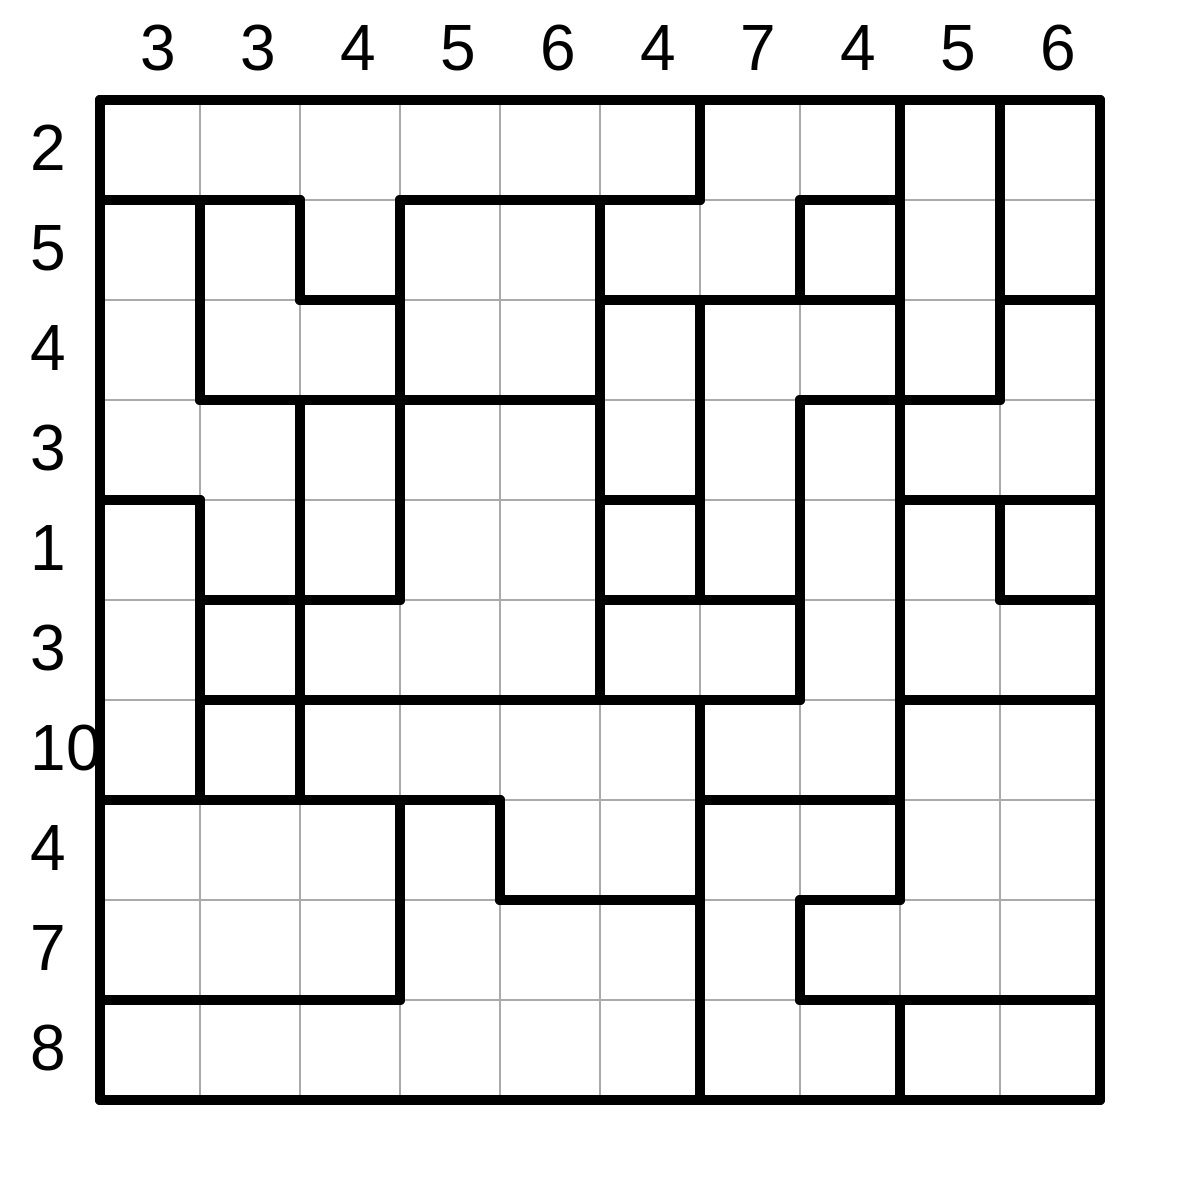

In [65]:
# TODO: integrate this drawing stuff with the game class as the "render" function

# draw the board (and build the interactions)
TILE_W = 100
TILE_H = 100

s = svg(1000,1000)

# make the tiles to click on
for j in range(BD_H):
    for i in range(BD_W):
        color = 'white'
        if False and (aquarium._getv(aquarium.water, i, j) == WATER):
            color = 'lightBlue'
        s.rect(i*TILE_W + TILE_W, j*TILE_H + TILE_H, TILE_W, TILE_H, color)


# make the lines around the board
s.line(TILE_W, TILE_H, TILE_W * (BD_W+1), TILE_H)
s.line(TILE_W * (BD_W+1), TILE_H, TILE_W * (BD_W+1), TILE_H * (BD_H+1))
s.line(TILE_W * (BD_W+1), TILE_H*(BD_H+1), TILE_W, TILE_H*(BD_H+1))
s.line(TILE_W, TILE_H*(BD_H+1), TILE_W, TILE_H)

# make the borders of the tanks
for j in range(BD_H):
    current_v = aquarium.getv(0, j)
    for i in range(1, BD_W):
        new_v = aquarium.getv(i, j)
        if new_v != current_v:
            s.line((i+1)*TILE_W, (j+1)*TILE_H, (i+1)*TILE_W, (j+2)*TILE_H)
            current_v = new_v
for i in range(BD_W):
    current_v = aquarium.getv(i, 0)
    for j in range(1, BD_H):
        new_v = aquarium.getv(i, j)
        if new_v != current_v:
            s.line((i+1)*TILE_W, (j+1)*TILE_H, (i+2)*TILE_W, (j+1)*TILE_H)
            current_v = new_v

# add some random numbers
for i in range(BD_W):
    s.text((i+1)*TILE_W+TILE_W*0.4, TILE_H*0.7, aquarium.column_water(i))
for j in range(BD_H):
    s.text(TILE_W*0.3, (j+1)*TILE_H+TILE_H*0.7, aquarium.row_water(j))
SVG(s.render())
